In [1]:
import glob
import io
import os
import mediapy as media
import numpy as np
from PIL import Image
from PIL import Image
import tensorflow_text
from tips.pytorch import image_encoder
from tips.pytorch import text_encoder
from tips.scenic.utils import feature_viz
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import transforms

2025-03-27 18:57:59.030716: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743119879.049996   95223 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743119879.055985   95223 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-27 18:57:59.076862: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/usr/mvl2/jdmcnw/Projects/2025/VOTS/TIPS/tips/pytorch/image_encoder.py:175: UserWarning: xFormers is not available (SwiGLU)
 

In [2]:
model_image = image_encoder.vit_small(
    img_size=448,
    patch_size=14,
    ffn_layer='mlp',
    block_chunks=0,
    init_values=1.0,
    interpolate_antialias=True,
    interpolate_offset=0.0,
)

In [3]:

# Add the checkpoints and tokenizer path.
image_encoder_checkpoint = '/usr/mvl2/jdmcnw/Projects/2025/VOTS/TIPS/tips/pytorch/checkpoints/tips_oss_s14_highres_distilled_vision.npz'  # @param {type: "string"}
text_encoder_checkpoint = '/usr/mvl2/jdmcnw/Projects/2025/VOTS/TIPS/tips/pytorch/checkpoints/tips_oss_s14_highres_distilled_text.npz'  # @param {type: "string"}
tokenizer_path = '/usr/mvl2/jdmcnw/Projects/2025/VOTS/TIPS/tips/pytorch/checkpoints/tokenizer.model'  # @param {type: "string"}

In [4]:
# Load checkpoint.
# Set the input image shape and variant.
image_size = 448  # @param {type: "number"}
variant = 'S'  # @param ['S', 'B', 'L', 'So400m', 'g']

weights_image = dict(np.load(image_encoder_checkpoint, allow_pickle=False))
for key in weights_image:
  weights_image[key] = torch.tensor(weights_image[key])
ffn_layer = 'swiglu' if variant == 'g' else 'mlp'

embeddings_image, spatial_features = [], []


In [5]:
# Set the input image shape and variant.
image_size = 448  # @param {type: "number"}
variant = 'S'  # @param ['S', 'B', 'L', 'So400m', 'g']


IMAGE_MEAN = (0, 0, 0)
IMAGE_STD = (1.0, 1.0, 1.0)
PATCH_SIZE = 14
MAX_LEN = 64
VOCAB_SIZE = 32000

# Add your images in this directory.
image_dir = 'images/inputs/basketball/color/'  # @param {type: "string"}
image_paths = glob.glob(os.path.join(image_dir, '*'))[:1]
# The text inputs to be contrasted.
text_inputs = [
    'A ship',
    'A lion',
    'a toy',
    'Seven Cats',
    'A laptop',
    'a cat',
    'a starry night',
    'A president',
]


In [6]:
# Load checkpoint.
weights_image = dict(np.load(image_encoder_checkpoint, allow_pickle=False))
for key in weights_image:
  weights_image[key] = torch.tensor(weights_image[key])
ffn_layer = 'swiglu' if variant == 'g' else 'mlp'

embeddings_image, spatial_features = [], []


def load_image_bytes(file_name):
  with open(file_name, 'rb') as fd:
    image_bytes = io.BytesIO(fd.read())
    pil_image = Image.open(image_bytes)
    transform = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        transforms.Normalize(IMAGE_MEAN, IMAGE_STD),
    ])
    input_tensor = transform(pil_image)
    input_batch = input_tensor.unsqueeze(0)

  return input_batch

with torch.no_grad():
  # Load the vision encoder.
  model_image = image_encoder.vit_small(
      img_size=image_size,
      patch_size=PATCH_SIZE,
      ffn_layer=ffn_layer,
      block_chunks=0,
      init_values=1.0,
      interpolate_antialias=True,
      interpolate_offset=0.0,
  )
  model_image.load_state_dict(weights_image)

  for image_path in image_paths:
    input_batch = load_image_bytes(image_path)
    output = model_image(input_batch)
    cls_token = feature_viz.normalize(
        output[0][0][0]
    )  # Choose the first CLS token.
    spatial_feature = torch.reshape(
        output[2],
        (1, int(image_size / PATCH_SIZE), int(image_size / PATCH_SIZE), -1),
    )
    spatial_features.append(spatial_feature)
    embeddings_image.append(cls_token)

In [7]:


model_image.eval()


VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 384, kernel_size=(14, 14), stride=(14, 14))
    (norm): Identity()
  )
  (blocks): ModuleList(
    (0-11): 12 x Block(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn): MemEffAttention(
        (qkv): Linear(in_features=384, out_features=1152, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): LayerScale()
      (drop_path1): Identity()
      (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=384, out_features=1536, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=1536, out_features=384, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
      (ls2): LayerScale()
      (drop_path2): Identity()
    )
  )
  (norm): LayerNorm(

##  Training DPT

In [8]:
#!pip install kagglehub

In [9]:
#import kagglehub

# Download latest version
#path = kagglehub.dataset_download("soumikrakshit/nyu-depth-v2")

#print("Path to dataset files:", path)

In [10]:
#!pip install torchmetrics

In [11]:
######### 

In [12]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.cuda.amp import GradScaler, autocast
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from pathlib import Path
import cv2 as cv
from PIL import Image

from sklearn.model_selection import train_test_split
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torchmetrics.image import StructuralSimilarityIndexMeasure as SSIM
from torchmetrics.regression import MeanSquaredError as MSE
from torchmetrics.collections import MetricCollection
import gc
from torchvision.transforms import Normalize

In [13]:
#import torch.multiprocessing as mp
#mp.set_start_method('spawn', force=True)


In [14]:
train_csv = Path('/usr/mvl2/jdmcnw/.cache/kagglehub/datasets/soumikrakshit/nyu-depth-v2/versions/1/nyu_data/data/nyu2_train.csv')
train_ims_path = Path('/usr/mvl2/jdmcnw/.cache/kagglehub/datasets/soumikrakshit/nyu-depth-v2/versions/1/nyu_data/data/nyu2_train')
base_path = Path('/usr/mvl2/jdmcnw/.cache/kagglehub/datasets/soumikrakshit/nyu-depth-v2/versions/1/nyu_data')


df = pd.read_csv(train_csv,header=None)
df[0] = df[0].map(lambda x:base_path/x)
df[1] = df[1].map(lambda x:base_path/x)
df.head()

train_df, val_df = train_test_split(df,test_size=0.1,shuffle=True)
val_df, test_df = train_test_split(val_df, test_size=0.1,shuffle=True)
train_df.reset_index(drop=True,inplace=True)
val_df.reset_index(drop=True,inplace=True)
test_df.reset_index(drop=True,inplace=True)
train_df=train_df[0:10000]
val_df=val_df[0:1000]
len(train_df),len(val_df), len(test_df)

(10000, 1000, 507)

In [15]:
""""
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class NYUv2TIPSDataset(Dataset):
    def __init__(self, dataframe, image_size, tips_encoder, transform=None):
        self.df = dataframe
        self.image_size = image_size
        self.device = device  # <- reusing global device
        self.encoder = tips_encoder.to(self.device).eval()
        self.transform = transform or transforms.Compose([
            transforms.Resize((image_size, image_size)),
            transforms.ToTensor(),
            transforms.Normalize((0, 0, 0), (1, 1, 1))
        ])

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        rgb_path, depth_path = self.df.iloc[idx]
        image = Image.open(rgb_path).convert('RGB')
        depth = Image.open(depth_path)

        # Transform inputs
        image = self.transform(image).to(self.device)  # <- move image to encoder's device
        depth = transforms.Resize((256, 256))(depth)
        depth = transforms.ToTensor()(depth)

        with torch.no_grad():
            features = self.encoder(image.unsqueeze(0))[2]  # spatial patch tokens [1, HW, D]
            B, HW, D = features.shape
            spatial = features.view(1, int(HW ** 0.5), int(HW ** 0.5), D).permute(0, 3, 1, 2).squeeze(0)

        return spatial, depth

"""

'"\nimport torch\nfrom torch.utils.data import Dataset\nfrom torchvision import transforms\nfrom PIL import Image\n\ndevice = torch.device(\'cuda\' if torch.cuda.is_available() else \'cpu\')\n\nclass NYUv2TIPSDataset(Dataset):\n    def __init__(self, dataframe, image_size, tips_encoder, transform=None):\n        self.df = dataframe\n        self.image_size = image_size\n        self.device = device  # <- reusing global device\n        self.encoder = tips_encoder.to(self.device).eval()\n        self.transform = transform or transforms.Compose([\n            transforms.Resize((image_size, image_size)),\n            transforms.ToTensor(),\n            transforms.Normalize((0, 0, 0), (1, 1, 1))\n        ])\n\n    def __len__(self):\n        return len(self.df)\n\n    def __getitem__(self, idx):\n        rgb_path, depth_path = self.df.iloc[idx]\n        image = Image.open(rgb_path).convert(\'RGB\')\n        depth = Image.open(depth_path)\n\n        # Transform inputs\n        image = self.t

In [16]:
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class NYUv2TIPSDataset(Dataset):
    def __init__(self, dataframe, image_size, tips_encoder, transform=None):
        self.df = dataframe
        self.image_size = image_size
        self.device = device  # Reuse global device
        self.encoder = tips_encoder.to(self.device).eval()
        self.transform = transform or transforms.Compose([
            transforms.Resize((image_size, image_size)),
            transforms.ToTensor(),
            transforms.Normalize((0, 0, 0), (1, 1, 1))
        ])

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        rgb_path, depth_path = self.df.iloc[idx]
        image = Image.open(rgb_path).convert('RGB')
        depth = Image.open(depth_path)

        # Transform inputs
        image = self.transform(image).to(self.device)
        depth = transforms.Resize((256, 256))(depth)
        depth = transforms.ToTensor()(depth)

        with torch.no_grad():
            output = self.encoder(image.unsqueeze(0))
            cls_token = output[0][0]         # Shape: [1, D]
            features = output[2]             # Shape: [1, HW, D]

            B, HW, D = features.shape
            spatial = features.view(B, int(HW ** 0.5), int(HW ** 0.5), D).permute(0, 3, 1, 2).squeeze(0)  # [D, H, W]

            # Inject CLS token
            cls_token = cls_token.view(D, 1, 1)  # [D, 1, 1]
            spatial = spatial + cls_token       # Add CLS token across all positions

        return spatial, depth


In [17]:
# This file implements a DPT-style decoder using frozen TIPS encoder features.

import torch
import torch.nn as nn
import torch.nn.functional as F


class ReassembleLayer(nn.Module):
    def __init__(self, in_channels, out_channels, scale_factor):
        super().__init__()
        self.project = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        self.scale_factor = scale_factor
        self.resample = nn.Upsample(scale_factor=scale_factor, mode='bilinear', align_corners=False)

    def forward(self, x):
        x = self.project(x)
        x = self.resample(x)
        return x


class FusionBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.residual_conv = nn.Sequential(
            nn.Conv2d(channels, channels, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(channels, channels, 3, padding=1),
            nn.ReLU(inplace=True)
        )
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)

    def forward(self, x, skip):
        # Resize skip if needed
        if x.shape[-2:] != skip.shape[-2:]:
            skip = F.interpolate(skip, size=x.shape[-2:], mode='bilinear', align_corners=False)
        x = self.residual_conv(x + skip)
        x = self.upsample(x)
        return x



class DPTDepthDecoder(nn.Module):
    def __init__(self, embed_dim=384, channels=256):
        super().__init__()
        self.reassemble_layers = nn.ModuleList([
            ReassembleLayer(embed_dim, channels, scale_factor=4),   # 32x32 -> 128x128
            ReassembleLayer(embed_dim, channels, scale_factor=2),   # 32x32 -> 64x64
            ReassembleLayer(embed_dim, channels, scale_factor=1),   # 32x32 -> 32x32
        ])

        self.fusion_blocks = nn.ModuleList([
            FusionBlock(channels),
            FusionBlock(channels),
        ])

        self.output_head = nn.Sequential(
            nn.Conv2d(channels, channels // 2, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(channels // 2, 1, 1)
        )

    def forward(self, spatial_feats):
        feats = [layer(spatial_feats) for layer in self.reassemble_layers]
        x = feats[-1]  # lowest res (32x32)
        x = self.fusion_blocks[0](x, feats[-2])  # 64x64
        x = self.fusion_blocks[1](x, feats[-3])  # 128x128
        depth = self.output_head(x)             # 128x128
        depth = F.interpolate(depth, scale_factor=2, mode='bilinear', align_corners=False)  # 256x256
        return depth


In [18]:
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn as nn

# Assume: `decoder` is DPTDepthDecoder, `tips_encoder` is frozen model_image from earlier
train_dataset = NYUv2TIPSDataset(train_df, image_size=448, tips_encoder=model_image)


train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True,  num_workers=0)

decoder = DPTDepthDecoder(embed_dim=384, channels=256).cuda()
criterion = nn.MSELoss()
optimizer = optim.Adam(decoder.parameters(), lr=1e-4)


In [19]:
import torch
from tqdm import tqdm
import time

# Make sure this is set earlier in your notebook/script
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
decoder = decoder.to(device)

print(f"✅ Using device: {device}")
num_epochs = 100

for epoch in range(num_epochs):
    decoder.train()
    total_loss = 0
    start_time = time.time()

    loop = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch}")

    for i, (features, gt_depth) in loop:
        # ⬅ Move inputs to device
        features = features.to(device)
        gt_depth = gt_depth.to(device)

        # Optional: print shape on first iteration
        if epoch == 0 and i == 0:
            print(f" ➤ Features: {features.shape}, Depth GT: {gt_depth.shape}")

        # Training step
        optimizer.zero_grad()
        pred_depth = decoder(features)
        loss = criterion(pred_depth, gt_depth)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        loop.set_postfix(batch_loss=loss.item())

    # Epoch summary
    avg_loss = total_loss / len(train_loader)
    duration = time.time() - start_time
    print(f"✅ Epoch {epoch} completed | Avg Loss: {avg_loss:.4f} | Time: {duration:.2f} sec")


✅ Using device: cuda


Epoch 0:   0%|          | 1/1250 [00:00<13:17,  1.57it/s, batch_loss=0.122]

 ➤ Features: torch.Size([8, 384, 32, 32]), Depth GT: torch.Size([8, 1, 256, 256])


Epoch 0: 100%|██████████| 1250/1250 [05:43<00:00,  3.64it/s, batch_loss=0.00328]


✅ Epoch 0 completed | Avg Loss: 0.0049 | Time: 343.40 sec


Epoch 1: 100%|██████████| 1250/1250 [04:37<00:00,  4.50it/s, batch_loss=0.0027] 


✅ Epoch 1 completed | Avg Loss: 0.0030 | Time: 277.57 sec


Epoch 2: 100%|██████████| 1250/1250 [04:33<00:00,  4.57it/s, batch_loss=0.00166] 


✅ Epoch 2 completed | Avg Loss: 0.0026 | Time: 273.64 sec


Epoch 3: 100%|██████████| 1250/1250 [04:39<00:00,  4.48it/s, batch_loss=0.0031]  


✅ Epoch 3 completed | Avg Loss: 0.0022 | Time: 279.27 sec


Epoch 4: 100%|██████████| 1250/1250 [04:34<00:00,  4.55it/s, batch_loss=0.00161] 


✅ Epoch 4 completed | Avg Loss: 0.0019 | Time: 274.47 sec


Epoch 5: 100%|██████████| 1250/1250 [04:34<00:00,  4.55it/s, batch_loss=0.00135] 


✅ Epoch 5 completed | Avg Loss: 0.0018 | Time: 274.76 sec


Epoch 6: 100%|██████████| 1250/1250 [04:31<00:00,  4.61it/s, batch_loss=0.00141] 


✅ Epoch 6 completed | Avg Loss: 0.0016 | Time: 271.19 sec


Epoch 7: 100%|██████████| 1250/1250 [04:29<00:00,  4.63it/s, batch_loss=0.00303] 


✅ Epoch 7 completed | Avg Loss: 0.0015 | Time: 269.91 sec


Epoch 8: 100%|██████████| 1250/1250 [04:31<00:00,  4.60it/s, batch_loss=0.00215] 


✅ Epoch 8 completed | Avg Loss: 0.0014 | Time: 271.61 sec


Epoch 9: 100%|██████████| 1250/1250 [04:48<00:00,  4.34it/s, batch_loss=0.00221] 


✅ Epoch 9 completed | Avg Loss: 0.0013 | Time: 288.12 sec


Epoch 10: 100%|██████████| 1250/1250 [04:33<00:00,  4.58it/s, batch_loss=0.000995]


✅ Epoch 10 completed | Avg Loss: 0.0013 | Time: 273.09 sec


Epoch 11: 100%|██████████| 1250/1250 [04:31<00:00,  4.60it/s, batch_loss=0.000903]


✅ Epoch 11 completed | Avg Loss: 0.0012 | Time: 271.90 sec


Epoch 12: 100%|██████████| 1250/1250 [04:37<00:00,  4.50it/s, batch_loss=0.00108] 


✅ Epoch 12 completed | Avg Loss: 0.0011 | Time: 277.52 sec


Epoch 13: 100%|██████████| 1250/1250 [04:29<00:00,  4.63it/s, batch_loss=0.000835]


✅ Epoch 13 completed | Avg Loss: 0.0011 | Time: 269.89 sec


Epoch 14: 100%|██████████| 1250/1250 [04:28<00:00,  4.66it/s, batch_loss=0.000876]


✅ Epoch 14 completed | Avg Loss: 0.0011 | Time: 268.01 sec


Epoch 15: 100%|██████████| 1250/1250 [04:31<00:00,  4.61it/s, batch_loss=0.000683]


✅ Epoch 15 completed | Avg Loss: 0.0010 | Time: 271.02 sec


Epoch 16: 100%|██████████| 1250/1250 [04:32<00:00,  4.58it/s, batch_loss=0.0004]  


✅ Epoch 16 completed | Avg Loss: 0.0010 | Time: 272.79 sec


Epoch 17: 100%|██████████| 1250/1250 [04:29<00:00,  4.64it/s, batch_loss=0.000937]


✅ Epoch 17 completed | Avg Loss: 0.0010 | Time: 269.12 sec


Epoch 18: 100%|██████████| 1250/1250 [04:31<00:00,  4.60it/s, batch_loss=0.000501]


✅ Epoch 18 completed | Avg Loss: 0.0009 | Time: 271.47 sec


Epoch 19: 100%|██████████| 1250/1250 [04:29<00:00,  4.65it/s, batch_loss=0.000935]


✅ Epoch 19 completed | Avg Loss: 0.0009 | Time: 269.08 sec


Epoch 20: 100%|██████████| 1250/1250 [04:29<00:00,  4.63it/s, batch_loss=0.000648]


✅ Epoch 20 completed | Avg Loss: 0.0009 | Time: 269.88 sec


Epoch 21: 100%|██████████| 1250/1250 [04:33<00:00,  4.57it/s, batch_loss=0.000535]


✅ Epoch 21 completed | Avg Loss: 0.0008 | Time: 273.48 sec


Epoch 22: 100%|██████████| 1250/1250 [04:32<00:00,  4.58it/s, batch_loss=0.00104] 


✅ Epoch 22 completed | Avg Loss: 0.0008 | Time: 272.67 sec


Epoch 23: 100%|██████████| 1250/1250 [04:28<00:00,  4.65it/s, batch_loss=0.00093] 


✅ Epoch 23 completed | Avg Loss: 0.0008 | Time: 268.89 sec


Epoch 24: 100%|██████████| 1250/1250 [04:28<00:00,  4.66it/s, batch_loss=0.000575]


✅ Epoch 24 completed | Avg Loss: 0.0008 | Time: 268.07 sec


Epoch 25: 100%|██████████| 1250/1250 [04:28<00:00,  4.66it/s, batch_loss=0.000825]


✅ Epoch 25 completed | Avg Loss: 0.0008 | Time: 268.20 sec


Epoch 26: 100%|██████████| 1250/1250 [04:29<00:00,  4.64it/s, batch_loss=0.000765]


✅ Epoch 26 completed | Avg Loss: 0.0007 | Time: 269.33 sec


Epoch 27: 100%|██████████| 1250/1250 [04:27<00:00,  4.66it/s, batch_loss=0.000557]


✅ Epoch 27 completed | Avg Loss: 0.0007 | Time: 267.96 sec


Epoch 28: 100%|██████████| 1250/1250 [04:29<00:00,  4.63it/s, batch_loss=0.00122] 


✅ Epoch 28 completed | Avg Loss: 0.0007 | Time: 269.74 sec


Epoch 29: 100%|██████████| 1250/1250 [04:30<00:00,  4.63it/s, batch_loss=0.000594]


✅ Epoch 29 completed | Avg Loss: 0.0007 | Time: 270.06 sec


Epoch 30: 100%|██████████| 1250/1250 [04:28<00:00,  4.66it/s, batch_loss=0.00113] 


✅ Epoch 30 completed | Avg Loss: 0.0007 | Time: 268.16 sec


Epoch 31: 100%|██████████| 1250/1250 [04:32<00:00,  4.60it/s, batch_loss=0.000707]


✅ Epoch 31 completed | Avg Loss: 0.0007 | Time: 272.01 sec


Epoch 32: 100%|██████████| 1250/1250 [04:28<00:00,  4.65it/s, batch_loss=0.000635]


✅ Epoch 32 completed | Avg Loss: 0.0007 | Time: 268.87 sec


Epoch 33: 100%|██████████| 1250/1250 [04:30<00:00,  4.63it/s, batch_loss=0.000524]


✅ Epoch 33 completed | Avg Loss: 0.0007 | Time: 270.02 sec


Epoch 34: 100%|██████████| 1250/1250 [04:30<00:00,  4.61it/s, batch_loss=0.000417]


✅ Epoch 34 completed | Avg Loss: 0.0007 | Time: 270.91 sec


Epoch 35: 100%|██████████| 1250/1250 [04:29<00:00,  4.64it/s, batch_loss=0.000421]


✅ Epoch 35 completed | Avg Loss: 0.0006 | Time: 269.43 sec


Epoch 36: 100%|██████████| 1250/1250 [04:28<00:00,  4.66it/s, batch_loss=0.000369]


✅ Epoch 36 completed | Avg Loss: 0.0006 | Time: 268.38 sec


Epoch 37: 100%|██████████| 1250/1250 [04:28<00:00,  4.65it/s, batch_loss=0.00072] 


✅ Epoch 37 completed | Avg Loss: 0.0006 | Time: 268.88 sec


Epoch 38: 100%|██████████| 1250/1250 [04:34<00:00,  4.56it/s, batch_loss=0.000469]


✅ Epoch 38 completed | Avg Loss: 0.0006 | Time: 274.12 sec


Epoch 39: 100%|██████████| 1250/1250 [04:34<00:00,  4.55it/s, batch_loss=0.000447]


✅ Epoch 39 completed | Avg Loss: 0.0006 | Time: 274.84 sec


Epoch 40: 100%|██████████| 1250/1250 [04:32<00:00,  4.58it/s, batch_loss=0.000576]


✅ Epoch 40 completed | Avg Loss: 0.0006 | Time: 272.78 sec


Epoch 41: 100%|██████████| 1250/1250 [04:30<00:00,  4.62it/s, batch_loss=0.000585]


✅ Epoch 41 completed | Avg Loss: 0.0006 | Time: 270.35 sec


Epoch 42: 100%|██████████| 1250/1250 [04:29<00:00,  4.63it/s, batch_loss=0.000486]


✅ Epoch 42 completed | Avg Loss: 0.0006 | Time: 269.82 sec


Epoch 43: 100%|██████████| 1250/1250 [04:31<00:00,  4.61it/s, batch_loss=0.000631]


✅ Epoch 43 completed | Avg Loss: 0.0006 | Time: 271.41 sec


Epoch 44: 100%|██████████| 1250/1250 [04:28<00:00,  4.66it/s, batch_loss=0.000318]


✅ Epoch 44 completed | Avg Loss: 0.0006 | Time: 268.17 sec


Epoch 45: 100%|██████████| 1250/1250 [04:29<00:00,  4.63it/s, batch_loss=0.000535]


✅ Epoch 45 completed | Avg Loss: 0.0006 | Time: 269.95 sec


Epoch 46: 100%|██████████| 1250/1250 [04:27<00:00,  4.67it/s, batch_loss=0.00051] 


✅ Epoch 46 completed | Avg Loss: 0.0005 | Time: 267.76 sec


Epoch 47: 100%|██████████| 1250/1250 [04:30<00:00,  4.62it/s, batch_loss=0.000406]


✅ Epoch 47 completed | Avg Loss: 0.0005 | Time: 270.42 sec


Epoch 48: 100%|██████████| 1250/1250 [04:30<00:00,  4.63it/s, batch_loss=0.000399]


✅ Epoch 48 completed | Avg Loss: 0.0005 | Time: 270.06 sec


Epoch 49: 100%|██████████| 1250/1250 [04:30<00:00,  4.62it/s, batch_loss=0.000836]


✅ Epoch 49 completed | Avg Loss: 0.0005 | Time: 270.75 sec


Epoch 50: 100%|██████████| 1250/1250 [04:30<00:00,  4.63it/s, batch_loss=0.000384]


✅ Epoch 50 completed | Avg Loss: 0.0005 | Time: 270.19 sec


Epoch 51: 100%|██████████| 1250/1250 [04:28<00:00,  4.66it/s, batch_loss=0.000494]


✅ Epoch 51 completed | Avg Loss: 0.0005 | Time: 268.23 sec


Epoch 52: 100%|██████████| 1250/1250 [04:27<00:00,  4.67it/s, batch_loss=0.000252]


✅ Epoch 52 completed | Avg Loss: 0.0005 | Time: 267.93 sec


Epoch 53: 100%|██████████| 1250/1250 [04:29<00:00,  4.64it/s, batch_loss=0.000744]


✅ Epoch 53 completed | Avg Loss: 0.0005 | Time: 269.52 sec


Epoch 54: 100%|██████████| 1250/1250 [04:27<00:00,  4.67it/s, batch_loss=0.000725]


✅ Epoch 54 completed | Avg Loss: 0.0005 | Time: 267.48 sec


Epoch 55: 100%|██████████| 1250/1250 [04:27<00:00,  4.68it/s, batch_loss=0.000424]


✅ Epoch 55 completed | Avg Loss: 0.0005 | Time: 267.07 sec


Epoch 56: 100%|██████████| 1250/1250 [04:31<00:00,  4.60it/s, batch_loss=0.000233]


✅ Epoch 56 completed | Avg Loss: 0.0005 | Time: 271.57 sec


Epoch 57: 100%|██████████| 1250/1250 [04:27<00:00,  4.67it/s, batch_loss=0.000792]


✅ Epoch 57 completed | Avg Loss: 0.0005 | Time: 267.75 sec


Epoch 58: 100%|██████████| 1250/1250 [04:30<00:00,  4.62it/s, batch_loss=0.000726]


✅ Epoch 58 completed | Avg Loss: 0.0005 | Time: 270.78 sec


Epoch 59: 100%|██████████| 1250/1250 [04:29<00:00,  4.64it/s, batch_loss=0.00037] 


✅ Epoch 59 completed | Avg Loss: 0.0005 | Time: 269.66 sec


Epoch 60: 100%|██████████| 1250/1250 [04:28<00:00,  4.66it/s, batch_loss=0.000496]


✅ Epoch 60 completed | Avg Loss: 0.0005 | Time: 268.46 sec


Epoch 61: 100%|██████████| 1250/1250 [04:29<00:00,  4.64it/s, batch_loss=0.000244]


✅ Epoch 61 completed | Avg Loss: 0.0005 | Time: 269.23 sec


Epoch 62: 100%|██████████| 1250/1250 [04:32<00:00,  4.59it/s, batch_loss=0.000661]


✅ Epoch 62 completed | Avg Loss: 0.0005 | Time: 272.47 sec


Epoch 63: 100%|██████████| 1250/1250 [04:28<00:00,  4.65it/s, batch_loss=0.000325]


✅ Epoch 63 completed | Avg Loss: 0.0005 | Time: 268.79 sec


Epoch 64: 100%|██████████| 1250/1250 [04:31<00:00,  4.61it/s, batch_loss=0.000853]


✅ Epoch 64 completed | Avg Loss: 0.0005 | Time: 271.40 sec


Epoch 65: 100%|██████████| 1250/1250 [04:33<00:00,  4.58it/s, batch_loss=0.00042] 


✅ Epoch 65 completed | Avg Loss: 0.0005 | Time: 273.05 sec


Epoch 66: 100%|██████████| 1250/1250 [04:30<00:00,  4.62it/s, batch_loss=0.000389]


✅ Epoch 66 completed | Avg Loss: 0.0004 | Time: 270.31 sec


Epoch 67: 100%|██████████| 1250/1250 [04:28<00:00,  4.65it/s, batch_loss=0.000574]


✅ Epoch 67 completed | Avg Loss: 0.0004 | Time: 268.60 sec


Epoch 68: 100%|██████████| 1250/1250 [04:30<00:00,  4.63it/s, batch_loss=0.000648]


✅ Epoch 68 completed | Avg Loss: 0.0004 | Time: 270.25 sec


Epoch 69: 100%|██████████| 1250/1250 [04:28<00:00,  4.65it/s, batch_loss=0.000313]


✅ Epoch 69 completed | Avg Loss: 0.0005 | Time: 268.63 sec


Epoch 70: 100%|██████████| 1250/1250 [04:26<00:00,  4.69it/s, batch_loss=0.000688]


✅ Epoch 70 completed | Avg Loss: 0.0004 | Time: 266.80 sec


Epoch 71: 100%|██████████| 1250/1250 [04:30<00:00,  4.61it/s, batch_loss=0.000504]


✅ Epoch 71 completed | Avg Loss: 0.0004 | Time: 270.95 sec


Epoch 72: 100%|██████████| 1250/1250 [04:28<00:00,  4.66it/s, batch_loss=0.000508]


✅ Epoch 72 completed | Avg Loss: 0.0004 | Time: 268.09 sec


Epoch 73: 100%|██████████| 1250/1250 [04:26<00:00,  4.69it/s, batch_loss=0.000408]


✅ Epoch 73 completed | Avg Loss: 0.0004 | Time: 266.50 sec


Epoch 74: 100%|██████████| 1250/1250 [04:29<00:00,  4.64it/s, batch_loss=0.000752]


✅ Epoch 74 completed | Avg Loss: 0.0004 | Time: 269.49 sec


Epoch 75: 100%|██████████| 1250/1250 [04:27<00:00,  4.68it/s, batch_loss=0.000391]


✅ Epoch 75 completed | Avg Loss: 0.0004 | Time: 267.09 sec


Epoch 76: 100%|██████████| 1250/1250 [04:26<00:00,  4.68it/s, batch_loss=0.000588]


✅ Epoch 76 completed | Avg Loss: 0.0004 | Time: 266.98 sec


Epoch 77: 100%|██████████| 1250/1250 [04:25<00:00,  4.71it/s, batch_loss=0.00034] 


✅ Epoch 77 completed | Avg Loss: 0.0004 | Time: 265.58 sec


Epoch 78: 100%|██████████| 1250/1250 [04:27<00:00,  4.67it/s, batch_loss=0.000212]


✅ Epoch 78 completed | Avg Loss: 0.0004 | Time: 267.61 sec


Epoch 79: 100%|██████████| 1250/1250 [04:37<00:00,  4.51it/s, batch_loss=0.000364]


✅ Epoch 79 completed | Avg Loss: 0.0004 | Time: 277.13 sec


Epoch 80: 100%|██████████| 1250/1250 [04:27<00:00,  4.68it/s, batch_loss=0.000445]


✅ Epoch 80 completed | Avg Loss: 0.0004 | Time: 267.26 sec


Epoch 81: 100%|██████████| 1250/1250 [04:29<00:00,  4.63it/s, batch_loss=0.000369]


✅ Epoch 81 completed | Avg Loss: 0.0004 | Time: 269.99 sec


Epoch 82: 100%|██████████| 1250/1250 [04:28<00:00,  4.65it/s, batch_loss=0.000368]


✅ Epoch 82 completed | Avg Loss: 0.0004 | Time: 268.75 sec


Epoch 83: 100%|██████████| 1250/1250 [04:29<00:00,  4.65it/s, batch_loss=0.000321]


✅ Epoch 83 completed | Avg Loss: 0.0004 | Time: 269.06 sec


Epoch 84: 100%|██████████| 1250/1250 [04:29<00:00,  4.64it/s, batch_loss=0.00057] 


✅ Epoch 84 completed | Avg Loss: 0.0004 | Time: 269.45 sec


Epoch 85: 100%|██████████| 1250/1250 [04:35<00:00,  4.54it/s, batch_loss=0.000534]


✅ Epoch 85 completed | Avg Loss: 0.0004 | Time: 275.29 sec


Epoch 86: 100%|██████████| 1250/1250 [04:26<00:00,  4.68it/s, batch_loss=0.000364]


✅ Epoch 86 completed | Avg Loss: 0.0004 | Time: 266.82 sec


Epoch 87: 100%|██████████| 1250/1250 [04:28<00:00,  4.66it/s, batch_loss=0.000543]


✅ Epoch 87 completed | Avg Loss: 0.0004 | Time: 268.01 sec


Epoch 88: 100%|██████████| 1250/1250 [04:29<00:00,  4.63it/s, batch_loss=0.00053] 


✅ Epoch 88 completed | Avg Loss: 0.0004 | Time: 269.79 sec


Epoch 89: 100%|██████████| 1250/1250 [04:29<00:00,  4.65it/s, batch_loss=0.000434]


✅ Epoch 89 completed | Avg Loss: 0.0004 | Time: 269.11 sec


Epoch 90: 100%|██████████| 1250/1250 [04:28<00:00,  4.66it/s, batch_loss=0.000494]


✅ Epoch 90 completed | Avg Loss: 0.0004 | Time: 268.38 sec


Epoch 91: 100%|██████████| 1250/1250 [04:29<00:00,  4.64it/s, batch_loss=0.00039] 


✅ Epoch 91 completed | Avg Loss: 0.0004 | Time: 269.39 sec


Epoch 92: 100%|██████████| 1250/1250 [04:27<00:00,  4.68it/s, batch_loss=0.000415]


✅ Epoch 92 completed | Avg Loss: 0.0004 | Time: 267.15 sec


Epoch 93: 100%|██████████| 1250/1250 [04:27<00:00,  4.67it/s, batch_loss=0.000354]


✅ Epoch 93 completed | Avg Loss: 0.0004 | Time: 267.75 sec


Epoch 94: 100%|██████████| 1250/1250 [04:32<00:00,  4.59it/s, batch_loss=0.000346]


✅ Epoch 94 completed | Avg Loss: 0.0004 | Time: 272.57 sec


Epoch 95: 100%|██████████| 1250/1250 [04:28<00:00,  4.65it/s, batch_loss=0.00032] 


✅ Epoch 95 completed | Avg Loss: 0.0004 | Time: 268.84 sec


Epoch 96: 100%|██████████| 1250/1250 [04:29<00:00,  4.64it/s, batch_loss=0.000434]


✅ Epoch 96 completed | Avg Loss: 0.0004 | Time: 269.31 sec


Epoch 97: 100%|██████████| 1250/1250 [04:29<00:00,  4.64it/s, batch_loss=0.000274]


✅ Epoch 97 completed | Avg Loss: 0.0004 | Time: 269.15 sec


Epoch 98: 100%|██████████| 1250/1250 [04:29<00:00,  4.64it/s, batch_loss=0.000586]


✅ Epoch 98 completed | Avg Loss: 0.0004 | Time: 269.23 sec


Epoch 99: 100%|██████████| 1250/1250 [04:30<00:00,  4.62it/s, batch_loss=0.000488]

✅ Epoch 99 completed | Avg Loss: 0.0004 | Time: 270.46 sec


# Validation

In [20]:
val_dataset = NYUv2TIPSDataset(val_df, image_size=448, tips_encoder=model_image)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=0)


In [21]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_depth_predictions(rgb_paths, preds, gts, n=4):
    for i in range(min(n, len(preds))):
        plt.figure(figsize=(12, 4))
        
        # Input RGB
        plt.subplot(1, 3, 1)
        img = Image.open(rgb_paths[i]).resize((256, 256))
        plt.imshow(img)
        plt.title("RGB Input")
        plt.axis("off")
        
        # Predicted Depth
        plt.subplot(1, 3, 2)
        plt.imshow(preds[i].squeeze(), cmap='inferno')
        plt.title("Predicted Depth")
        plt.axis("off")
        
        # Ground Truth Depth
        plt.subplot(1, 3, 3)
        plt.imshow(gts[i].squeeze(), cmap='inferno')
        plt.title("Ground Truth Depth")
        plt.axis("off")
        
        plt.tight_layout()
        plt.show()


In [22]:
from sklearn.metrics import mean_squared_error

decoder.eval()
all_preds, all_gts, all_rgb_paths = [], [], []

with torch.no_grad():
    for idx, (features, gt_depth) in enumerate(val_loader):
        features, gt_depth = features.to(device), gt_depth.to(device)
        preds = decoder(features)

        all_preds.append(preds.cpu())
        all_gts.append(gt_depth.cpu())

        # Save RGB paths to visualize later
        batch_paths = [str(val_df.iloc[i + idx * val_loader.batch_size, 0]) for i in range(len(features))]
        all_rgb_paths.extend(batch_paths)

        if idx >= 2: break  # Limit to a few batches for sanity check

all_preds = torch.cat(all_preds)
all_gts = torch.cat(all_gts)


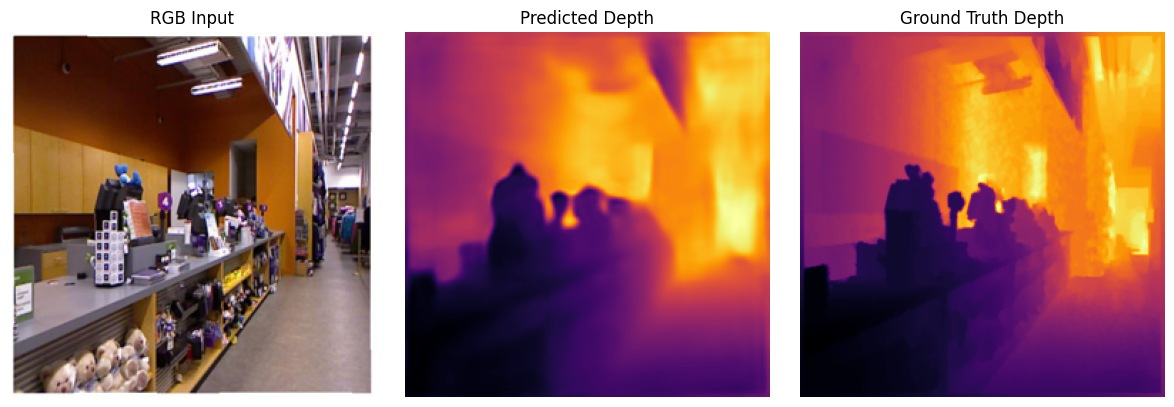

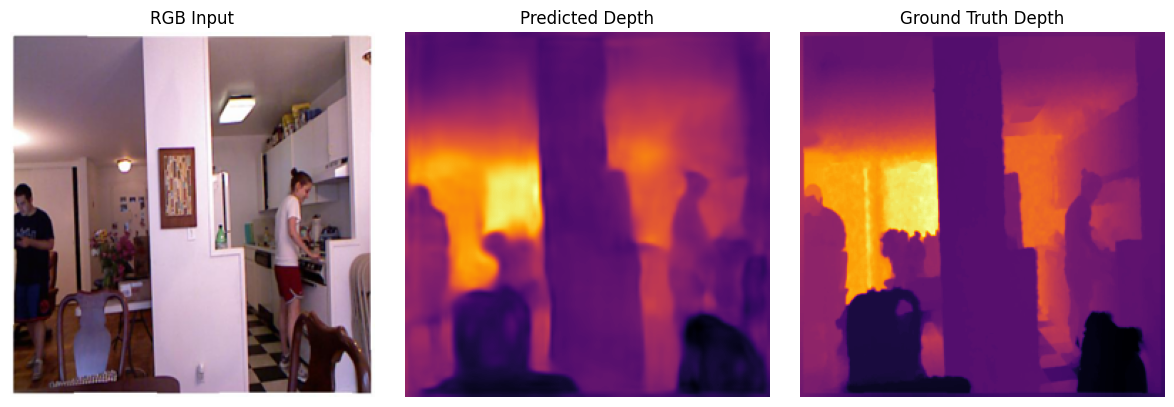

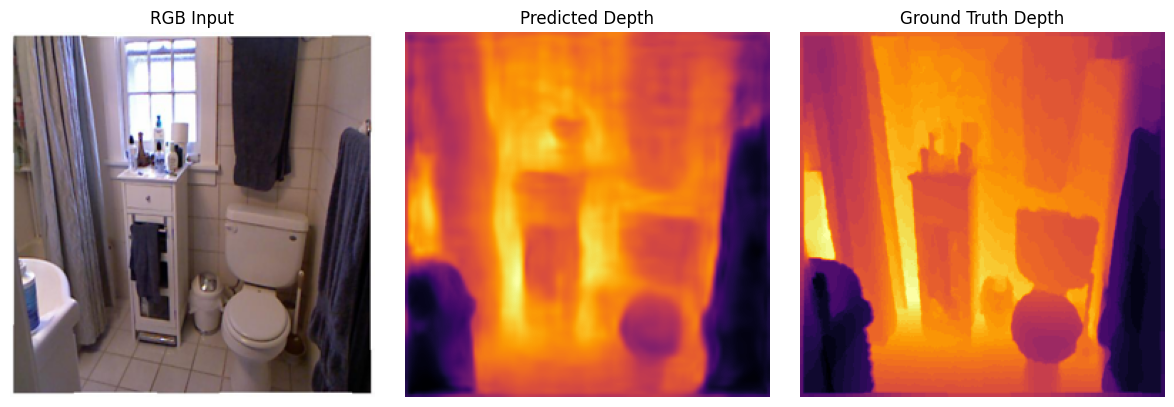

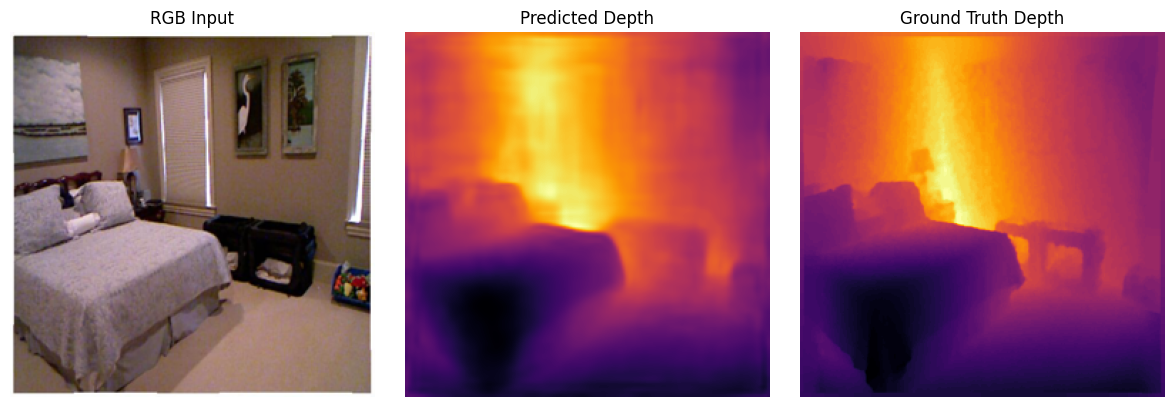

In [23]:
visualize_depth_predictions(all_rgb_paths, all_preds, all_gts, n=4)


In [24]:
def compute_rmse(pred, gt):
    return torch.sqrt(torch.mean((pred - gt) ** 2)).item()

rmse_val = compute_rmse(all_preds, all_gts)
print(f"🔎 RMSE (Validation, few batches): {rmse_val:.4f}")


🔎 RMSE (Validation, few batches): 0.0336


# Saving the model weights

In [25]:
save_path = f"checkpoints/dpt_decoder_epoch_{epoch}.pth"
torch.save(decoder.state_dict(), save_path)
print(f"💾 Saved decoder weights to {save_path}")

💾 Saved decoder weights to checkpoints/dpt_decoder_epoch_99.pth
